Inspired by https://www.kaggle.com/code/kcostya/convlstm-convolutional-lstm-network-tutorial

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

location = "remote"
if location == "remote":
    # TODO: hacky, shouldn't be necessary
    os.environ["WANDB_NOTEBOOK_NAME"] = "lustre_scratch/coralshift/notebooks/conv_lstm.ipynb"
    os.chdir("/lustre_scratch/orlando-code/coralshift/")


In [3]:
from __future__ import annotations

from pathlib import Path
import xarray as xa
import numpy as np

import wandb
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
# importing entire keras library leads to quasi-errors: https://stackoverflow.com/questions/65493824/tensorflow-gpu-memory-allocation
from tensorflow.keras import layers, models, losses, optimizers, callbacks


import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbCallback


# from sklearn import model_selection
# from sklearn.preprocessing import normalize
# from scipy.interpolate import interp2d
# from sklearn.utils import class_weight

import xbatcher

from sklearn.utils import class_weight
# import rasterio
# # from rasterio.plot import show
# import rioxarray as rio

# # from bs4 import BeautifulSoup
# # import requests


#issues with numpy deprecation in pytorch_env
from coralshift.processing import spatial_data
from coralshift.utils import file_ops, directories
from coralshift.plotting import spatial_plots, model_results
from coralshift.dataloading import data_structure, climate_data

from keras.models import Sequential
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
# import keras
import numpy as np
import pylab as plt

# from keras.layers import Flatten

2023-06-12 15:31:15.578042: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [25]:
!nvidia-smi
print(tf.config.list_physical_devices())

Mon Jun 12 16:05:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:85:00.0 Off |                    0 |
| N/A   31C    P0    46W / 163W |  31984MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:86:00.0 Off |                    0 |
| N/A   

In [5]:

def calc_class_weights_dict(ys: np.array) -> dict:
    y_vals = np.unique(ys)
    weight_list = class_weight.compute_class_weight('balanced', classes=y_vals, y=np.reshape(ys,-1))
    weight_dict = {}
    for i, val in enumerate(y_vals):
        weight_dict[val] = weight_list[i]

    return weight_dict

def negative_log_likelihood(y: np.ndarray, y_pred: np.ndarray, class_weights: np.ndarray = None) -> float:
    """Compute binary cross-entropy loss between ground-truth binary labels and predicted probabilities,
    incorporating class weights.

    Parameters
    ----------
    y (np.ndarray): true binary labels, where 0 represents the negative class
    y_pred (np.ndarray): predicted labels (as probability value between 0 and 1)
    class_weights (np.ndarray): weights for each class. If None, no class weights will be applied.

    Returns
    -------
    float: negative log likelihood loss computed using binary cross-entropy loss between 'y' and 'y_pred',
    incorporating class weights if provided
    """
    bce = tf.keras.losses.BinaryCrossentropy()  

    if class_weights is not None:
        sample_weights = tf.gather(class_weights, np.asarray(y,dtype=np.int32))
        return bce(y, y_pred, sample_weight=sample_weights)

    return bce(y, y_pred)


In [6]:
ds_man = data_structure.MyDatasets()
ds_man.set_location(location)

noaa_features = ['mlotst', 'bottomT', 'uo', 'so', 'zos', 'thetao', 'vo']

# TODO: transparency in preprocessing to get to this (probably split into separate gt datarray)
ds_man.add_dataset(
    "monthly_climate_1_12", xa.open_dataset(
        ds_man.get_location() / "global_ocean_reanalysis/monthly_means/coral_climate_1_12.nc")
)

ds_man.add_dataset(
    "monthly_climate_features", ds_man.get_dataset("monthly_climate_1_12")[noaa_features]
)

# # ds_man.add_dataset(
# #     "monthly_climate_1_12_X_y_np", spatial_data.filter_out_nans(
# #         spatial_data.xa_ds_to_3d_numpy(ds_man.get_dataset("monthly_climate_1_12")), 
# #         np.array(ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"].isel(time=-1)).reshape(-1, 1))
# # )
# ds_man.add_datasets(
#     ["monthly_climate_1_12_X", "monthly_climate_1_12_y"], 
#         spatial_data.process_xa_ds_for_ml(ds_man.get_dataset("monthly_climate_1_12"), 
#         feature_vars=noaa_features, gt_var="coral_algae_1-12_degree")
# )

# # TODO: handle depth
# ds_man.add_dataset(
#     "daily_climate_1_12", spatial_data.generate_and_add_gt_to_xa_d(xa.open_dataset(
#         Path(ds_man.get_location() / "global_ocean_reanalysis/daily_means/dailies_combined.nc")).isel(depth=0),
#         ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"])
# )

# # TODO: streamline checking and saving process
# daily_climate_1_12_X_file_path = ds_man.get_location() / "global_ocean_reanalysis/daily_means/daily_climate_1_12_X.npy"
# # if daily_climate_1_12_X numpy array doesn't exist, generate and save
# if not file_ops.check_file_exists(filepath = daily_climate_1_12_X_file_path):
#     daily_climate_1_12_X = spatial_data.process_xa_ds_for_ml(ds_man.get_dataset("daily_climate_1_12"),
#         feature_vars = noaa_features)
#     np.save(daily_climate_1_12_X_file_path, daily_climate_1_12_X) 
#     ds_man.add_dataset("daily_climate_1_12_X", np.load(daily_climate_1_12_X_file_path))
# else:
#     ds_man.add_dataset("daily_climate_1_12_X", np.load(daily_climate_1_12_X_file_path))

# daily_climate_1_12_padded_1_file_path = ds_man.get_location() / "global_ocean_reanalysis/daily_means/daily_climate_1_12_padded_1.nc"
# # if daily_climate_1_12_padded_1 .nc file doesn't exist, generate and save
# if not file_ops.check_file_exists(filepath = daily_climate_1_12_padded_1_file_path):
#     daily_climate_1_12_padded_1 = spatial_data.spatially_buffer_timeseries(
#         ds_man.get_dataset("daily_climate_1_12"), buffer_size=1, exclude_vars = ["spatial_ref", "coral_algae_gt"])
#     daily_climate_1_12_padded_1.to_netcdf(filepath = daily_climate_1_12_padded_1_file_path)
#     ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))
# else:
#     ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))

# # add in ground truth to padded
# ds_man.add_dataset(
#     "daily_climate_1_12_padded_1_gt", spatial_data.generate_and_add_gt_to_xa_d(
#         ds_man.get_dataset("daily_climate_1_12_padded_1"),
#         ds_man.get_dataset("monthly_climate_1_12")["coral_algae_1-12_degree"])
# )

# ds_man.add_dataset(
#     "bathymetry_A", rio.open_rasterio(
#         rasterio.open(ds_man.get_location() / "bathymetry/GBR_30m/Great_Barrier_Reef_A_2020_30m_MSL_cog.tif"),
#         ).rename("bathymetry_A").rename({"x": "longitude", "y": "latitude"})
# )

In [7]:
# xa_coral_climate_1_12_features = ds_man.get_dataset("monthly_climate_features")
xa_coral_climate_1_12 = ds_man.get_dataset("monthly_climate_1_12")

# xa_coral_climate_1_12_working = xa_coral_climate_1_12

In [9]:

(train_Xs, train_ys), train_subsample, train_lat_lons_vals_dict = spatial_data.generate_patch(xa_ds=xa_coral_climate_1_12, lat_lon_starts=(-10,142), coord_range=(-6,6), onehot=True)
(test_Xs, test_ys), test_subsample, test_lat_lons_vals_dict = spatial_data.generate_patch(xa_ds=xa_coral_climate_1_12, lat_lon_starts=(-10,142), coord_range=(-6,6))

print("train_Xs shape: ", train_Xs.shape, "train_ys shape: ", train_ys.shape)
print("test_Xs shape: ", test_Xs.shape, "test_ys shape: ", test_ys.shape)

train_spatial_Xs = train_Xs.reshape((72,72,336,8))
train_spatial_ys = train_ys.reshape((72,72,336))[:,:,0].squeeze()
test_spatial_Xs = test_Xs.reshape((72,72,336,8))
test_spatial_ys = test_ys.reshape((72,72,336))[:,:,0].squeeze()



# train_Xs_lstm_shape = train_Xs_lstm.shape
# train_ys_lstm_shape = train_ys_lstm.shape
# test_Xs_lstm_shape = test_Xs_lstm.shape
# test_ys_lstm_shape = test_ys_lstm.shape

# train_Xs_convlstm = train_Xs_lstm.reshape(
#     int(np.sqrt(train_Xs_lstm_shape[0])), int(np.sqrt(train_Xs_lstm_shape[0])),train_Xs_lstm_shape[1],train_Xs_lstm_shape[2])
# train_ys_convlstm = train_ys_lstm.reshape(
#     int(np.sqrt(train_ys_lstm_shape[0])), int(np.sqrt(train_ys_lstm_shape[0])), train_ys_lstm_shape[1])

# test_Xs_convlstm = test_Xs_lstm.reshape(
#     int(np.sqrt(test_Xs_lstm_shape[0])), int(np.sqrt(test_Xs_lstm_shape[0])),test_Xs_lstm_shape[1],test_Xs_lstm_shape[2])
# test_ys_convlstm = test_ys_lstm.reshape(
#     int(np.sqrt(test_ys_lstm_shape[0])), int(np.sqrt(test_ys_lstm_shape[0])), test_ys_lstm_shape[1])



# train_spatial_Xs = train_Xs.reshape((72,72,336,8))
# train_spatial_ys = train_ys.reshape((72,72,336))[:,:,0].squeeze()
# test_spatial_Xs = test_Xs.reshape((72,72,336,8))
# test_spatial_ys = test_ys.reshape((72,72,336))[:,:,0].squeeze()

print("train_spatial_Xs shape: ", train_spatial_Xs.shape, "train_spatial_ys shape: ", train_spatial_ys.shape)
print("test_spatial_Xs shape: ", test_spatial_Xs.shape, "test_spatial_ys shape: ", test_spatial_ys.shape)

/lustre_scratch/orlando-code/coralshift/coralshift/processing/spatial_data.py:1062: UserWarning: rename 'latitude' to 'latitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  temp_xa_d = xa_d.rename(
/lustre_scratch/orlando-code/coralshift/coralshift/processing/spatial_data.py:1062: UserWarning: rename 'longitude' to 'longitude' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  temp_xa_d = xa_d.rename(
/lustre_scratch/orlando-code/coralshift/coralshift/processing/spatial_data.py:1062: UserWarning: rename 'time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  temp_xa_d = xa_d.rename(
/lustre_scratch/orlando-code/coralshift/coralshift/processing/spatial_data.py:1062: UserWarning: rename 'latitude' to 'latitude' does not create an index anymore. 

train_Xs shape:  (5184, 336, 8) train_ys shape:  (5184, 336)
test_Xs shape:  (5184, 336, 8) test_ys shape:  (5184, 336)
train_spatial_Xs shape:  (72, 72, 336, 8) train_spatial_ys shape:  (72, 72)
test_spatial_Xs shape:  (72, 72, 336, 8) test_spatial_ys shape:  (72, 72)


In [10]:
num_samples = 5

spatial_Xs = train_spatial_Xs
spatial_ys = train_spatial_ys

# Move the axes to the desired positions
# Repeat the array 100 times along the first axis
padded_spatial_Xs = np.tile(np.moveaxis(spatial_Xs, [0, 1, 2, 3], [1, 2, 0, 3]), (num_samples, 1, 1, 1, 1)).astype("float16")[:,-10:,...]
# padded_spatial_Xs.shape

# Add an extra dimension at axis 1
# Repeat the array num_samples times along the first axis and 3 times along the last axis
padded_spatial_ys = np.tile(np.expand_dims(spatial_ys, axis=(0,1,4)), (num_samples, 336, 1, 1, 8)).astype("int8")[:,-10:,...]

print("For reference: (num_samples, sequence_length, width, height, num_features)")
print("padded_spatial_Xs shape: ", padded_spatial_Xs.shape, "padded_spatial_ys shape: ", padded_spatial_ys.shape)

For reference: (num_samples, sequence_length, width, height, num_features)
padded_spatial_Xs shape:  (5, 10, 72, 72, 8) padded_spatial_ys shape:  (5, 10, 72, 72, 8)


In [ ]:
# # These are the usual ipython objects, including this one you are creating
# ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# # Get a sorted list of the objects and their sizes
# list_of_sizes = sorted([(x, sys.getsizeof(globals().get(x))/1e6) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
# print("MB", list_of_sizes)

In [ ]:
class_weights = calc_class_weights_dict(padded_spatial_ys[0,0,:,:,0])
class_weights

{0: 0.5849695328368314, 1: 3.442231075697211}

In [22]:
train_spatial_ys.shape

(72, 72)

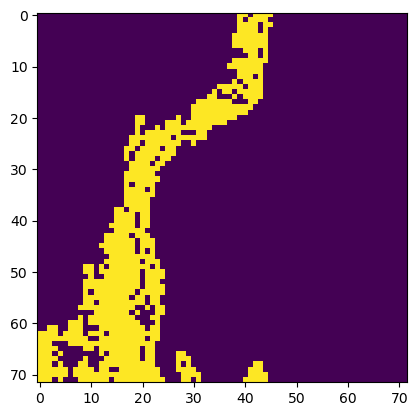

In [24]:
plt.imshow(train_spatial_ys)

In [26]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *padded_spatial_Xs.shape[2:]))
# inp = layers.Input(shape=(None, *x_train.shape[2:]))

# TODO: add config file, potentially with smaller learning rate
# https://stackoverflow.com/questions/40050397/deep-learning-nan-loss-reasons
# mirrored_strategy leads to nan loss values
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():

    # We will construct 3 `ConvLSTM2D` layers with batch normalization
    # 
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(5, 5),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(inp)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(3, 3),
        padding="same",
        return_sequences=True,
        activation="relu",
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.ConvLSTM2D(
        filters=64,
        kernel_size=(1, 1),
        padding="same",
        return_sequences=False,
        activation="relu",
    )(x)

    # Reshape the output tensor to match the target shape (num_samples, 1, rows, cols, 1)
    # x = layers.Reshape((1, *x.shape[2:]))(x)
    x= layers.Dense(1)(x)

    # # Add a final Conv3D layer for the spatiotemporal outputs
    # x = layers.Conv3D(
    #     filters=8, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
    # )(x)

    # Next, we will build the complete model and compile it.
    model = models.Model(inp, x)

    # TODO: include weighting of classes: https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy
    model.compile(
        loss=losses.binary_crossentropy,
        optimizer=optimizers.Adam(learning_rate=1e-3),
    )


# with mirrored_strategy.scope():

#     # We will construct 3 `ConvLSTM2D` layers with batch normalization,
#     # followed by a `Conv3D` layer for the spatiotemporal outputs.

#     # apply first layer to oinput layer and assign layer output to 'x'
#     x = layers.ConvLSTM2D(
#         filters=64,
#         kernel_size=(5, 5),
#         padding="same",
#         return_sequences=True,
#         activation="relu",
#     )(inp)
#     # apply subsequent layers to the output of the previous layer via 'x'
#     x = layers.BatchNormalization()(x)
#     x = layers.ConvLSTM2D(
#         filters=64,
#         kernel_size=(3, 3),
#         padding="same",
#         return_sequences=True,
#         activation="relu",
#     )(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.ConvLSTM2D(
#         filters=64,
#         kernel_size=(1, 1),
#         padding="same",
#         return_sequences=True,
#         activation="relu",
#     )(x)
#     x = layers.Conv3D(
#         filters=8, kernel_size=(3, 3, 3), activation="sigmoid", padding="same",
#         # filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
#     )(x)
#     # TODO: what happens if I replace the conv3D layer with e.g. a dense or third convlstm2d?

#     # the model is constructed from the input layer and 'x', the output from the last layer
#     model = models.Model(inp, x)

    
#     # TODO: include weighting of classes: https://stackoverflow.com/questions/46009619/keras-weighted-binary-crossentropy
#     model.compile(
#         loss=losses.binary_crossentropy, optimizer=optimizers.Adam(learning_rate=1e-3),
#     )



# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(5, 5),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(inp)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.BatchNormalization()(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(1, 1),
#     padding="same",
#     return_sequences=True,
#     activation="relu",
# )(x)
# x = layers.Conv3D(
#     filters=8, kernel_size=(3, 3, 3), activation="sigmoid", padding="same",
#     # filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"

# )(x)

# mirrored_strategy = tf.distribute.MirroredStrategy()

# # Next, we will build the complete model and compile it.
# model = keras.models.Model(inp, x)

# model.compile(
#     loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=1e-3),
# )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [27]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, 72, 72, 8)  0         
                             ]                                   
                                                                 
 conv_lstm2d_9 (ConvLSTM2D)  (None, None, 72, 72, 64)  461056    
                                                                 
 batch_normalization_6 (Batc  (None, None, 72, 72, 64)  256      
 hNormalization)                                                 
                                                                 
 conv_lstm2d_10 (ConvLSTM2D)  (None, None, 72, 72, 64)  295168   
                                                                 
 batch_normalization_7 (Batc  (None, None, 72, 72, 64)  256      
 hNormalization)                                                 
                                                           

In [14]:
padded_spatial_Xs.shape

(5, 10, 72, 72, 8)

In [13]:
# Define some callbacks to improve training. Patience measured in number of epochs.
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 4
batch_size = 2

# Start a run, tracking hyperparameters
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="coralshift_test",
# )

# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         print(np.sum(model.trainable_variables))
# my_callback = myCallback()



# with tf.device("/GPU:0"):
# Fit the model to the training data.
model.fit(
    # x_train,
    # y_train,
    padded_spatial_Xs,
    padded_spatial_ys,
    # class_weight=class_weights,
    batch_size=batch_size,
    epochs=epochs,
    # validation_data=(x_val, y_val),
    validation_data=(padded_spatial_Xs[-10:], padded_spatial_ys[-10:]),
    callbacks=[early_stopping, reduce_lr,
        # WandbMetricsLogger(log_freq=5), WandbModelCheckpoint("models"),
        # WandbCallback(training_data=(padded_spatial_Xs,padded_spatial_ys), log_weights=True, log_gradients=True)
])

# wandb.finish()

Epoch 1/4
INFO:tensorflow:batch_all_reduce: 15 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 15 all-reduces with algorithm = nccl, num_packs = 1


2023-06-12 15:33:06.615818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-06-12 15:33:07.203671: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
libibverbs: Warning: couldn't open config directory '/etc/libibverbs.d'.
2023-06-12 15:33:12.043406: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7ef30c3119d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-12 15:33:12.043485: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla V100-SXM2-32GB-LS, Compute Capability 7.0
2023-06-12 15:33:12.043500: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla V100-SXM2-32GB-LS, Compute Capability 7.0
2023-06-12 15:33:12.055179: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
202

2/3 [===================>..........] - ETA: 0s - loss: 0.9909 

2023-06-12 15:33:13.784077: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at transpose_op.cc:142 : INVALID_ARGUMENT: transpose expects a vector of size 4. But input(1) is a vector of size 5


InvalidArgumentError: Graph execution error:

3 root error(s) found.
  (0) INVALID_ARGUMENT:  transpose expects a vector of size 4. But input(1) is a vector of size 5
	 [[{{node gradient_tape/replica_1/model_1/batch_normalization_3/FusedBatchNormGradV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
	 [[update_1_15/AssignAddVariableOp/_949]]
	 [[div_no_nan/ReadVariableOp_2/_924]]
  (1) INVALID_ARGUMENT:  transpose expects a vector of size 4. But input(1) is a vector of size 5
	 [[{{node gradient_tape/replica_1/model_1/batch_normalization_3/FusedBatchNormGradV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
	 [[update_1_15/AssignAddVariableOp/_949]]
  (2) INVALID_ARGUMENT:  transpose expects a vector of size 4. But input(1) is a vector of size 5
	 [[{{node gradient_tape/replica_1/model_1/batch_normalization_3/FusedBatchNormGradV3-0-0-TransposeNCDHWToNDHWC-LayoutOptimizer}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_23130]

In [104]:
class_weights

array([0.58496953, 3.44223108])

In [149]:
pred = model.predict(padded_spatial_Xs)

4/4 [==============================] - 1s 164ms/step


In [150]:
padded_spatial_Xs.shape

(100, 12, 72, 72, 8)

In [146]:
pred.shape

(100, 12, 72, 72, 1)

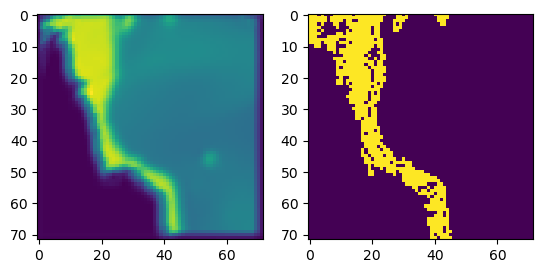

In [153]:
f,ax = plt.subplots(1,2)
im = ax[0].imshow(pred[0,0,:,:,0])
im2 = ax[1].imshow(padded_spatial_ys[0,0,:,:,0])
# f.colorbar(im)

In [ ]:
# # inputs of form: (samples, seq_length, height, width, features)
# # output will have a single feature: the ground truth
# # where samples here are different snapshots of the landscape: will want to set
# # up so can control geographically where they're (seq_length, height, width, features) 
# # drawn from 
# input_array = np.random.uniform(low=0, high=10, size=(100, 5, 40, 40, 3))
# label_array = np.random.choice([0, 1], size=(100, 1, 40, 40, 3))

# print("input_array shape: ", input_array.shape)
# print("label_array shape: ", label_array.shape)

# # generate 10 samples (10 chunks sent to ml-processed numpy arrays)



In [22]:
seq = Sequential()

filters = 40

input_array = padded_spatial_Xs
label_array = padded_spatial_ys

rows, cols = input_array.shape[2], input_array.shape[3]
len_seq = input_array.shape[1]
num_features = input_array.shape[-1]
num_samples = input_array.shape[0]
# rows, cols = 40, 40
kernel_dim = 3


input = keras.Input(shape=(len_seq, rows, cols, num_features),name="input")

# class myConvLSTM:

    # def model_structure(filters, kernel_dim)
seq.add(ConvLSTM2D(filters=filters, kernel_size=(kernel_dim, kernel_dim),
                data_format="channels_first", recurrent_activation="hard_sigmoid", activation="tanh",
                padding='same', return_sequences=True)(input))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=filters, kernel_size=(kernel_dim, kernel_dim),
                data_format="channels_first",
                padding='same', return_sequences=True))
seq.add(BatchNormalization())

# seq.add(ConvLSTM2D(filters=filters, kernel_size=(kernel_dim, kernel_dim),
#                 padding='same', return_sequences=True))
# seq.add(BatchNormalization())

# seq.add(ConvLSTM2D(filters=filters, kernel_size=(kernel_dim, kernel_dim),
#                 padding='same', return_sequences=True))
# seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(kernel_dim, kernel_dim, kernel_dim),
            activation='sigmoid',
            padding='same', data_format='channels_first'))

# in order to evaluate against labels of shape (samples, 1, row, col, 1) I think I need to compress this down

# seq.add(Flatten())
seq.compile(loss='binary_crossentropy', optimizer='adadelta')

# # Modify the loss function to account for the new label shape
# def binary_sequence_loss(y, y_pred):
#     return binary_crossentropy(y[:, -1], y_pred[:, -1, ...])

# Compile the model with the new loss function
# seq.compile(loss=binary_sequence_loss, optimizer='adadelta')
# https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
seq.summary()

seq.fit(input_array, label_array, batch_size=10,
        epochs=5, validation_split=0.05)

NameError: name 'keras' is not defined

In [ ]:
pred = seq.predict(input_array)

In [28]:
pred.shape
plt.imshow(pred[0,0,:,:,0])

NameError: name 'pred' is not defined

In [ ]:
seq.fit(input_array, label_array, batch_size=10,
        epochs=5, validation_split=0.05)

In [ ]:
# load in dasked xarray for area

daily_climate_1_12_padded_1_file_path = ds_man.get_location() / "global_ocean_reanalysis/daily_means/daily_climate_1_12_padded_1.nc"
# if daily_climate_1_12_padded_1 .nc file doesn't exist, generate and save
if not file_ops.check_file_exists(filepath = daily_climate_1_12_padded_1_file_path):
    daily_climate_1_12_padded_1 = spatial_data.spatially_buffer_timeseries(
        ds_man.get_dataset("daily_climate_1_12"), buffer_size=1, exclude_vars = ["spatial_ref", "coral_algae_gt"])
    daily_climate_1_12_padded_1.to_netcdf(filepath = daily_climate_1_12_padded_1_file_path)
    ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))
else:
    ds_man.add_dataset("daily_climate_1_12_padded_1", xa.open_dataset(daily_climate_1_12_padded_1_file_path))

# 

In [ ]:
# inputs of form: (samples, seq_length, height, width, features)
# output will have a single feature: the ground truth
# where samples here are different snapshots of the landscape: will want to set
# up so can control geographically where they're (seq_length, height, width, features) 
# drawn from 

# generate 10 samples (10 chunks sent to ml-processed numpy arrays)

# Divider
https://keras.io/examples/vision/conv_lstm/

In [ ]:
# TODO:
# try with longer timeseries
# validate on other patch
# deal with class imbalance